In [15]:
import pandas as pd
import numpy as np 
import pdb
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('display.max_columns', 100)

from torch.utils.data import Dataset, DataLoader
import torch
import time
import torchvision
import datetime
import glob
import ast

In [16]:
games_df    = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/games.csv")
scouting_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv")
players_df  = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/players.csv")
plays_df    = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/plays.csv")

week1_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week1.csv")
week2_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week2.csv")
week3_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week3.csv")
week4_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week4.csv")
week5_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week5.csv")
week6_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week6.csv")
week7_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week7.csv")
week8_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week8.csv")


frames = [week1_df, week2_df, week3_df, week4_df, week5_df, week6_df, week7_df, week8_df]
tracking = pd.concat(frames)

tracking = tracking[tracking.x.notnull()]
tracking = tracking[tracking.y.notnull()]

# Prepare for too few/many men on the field error
filter_out     = tracking.groupby(['gameId', 'playId', 'frameId'])['nflId'].count()
filter_out_ids = filter_out[filter_out != 22].index

tracking_ids = tracking.set_index(['gameId', 'playId', 'frameId']).index
tracking = tracking[~tracking_ids.isin(filter_out_ids)]

tracking['nflId'] = tracking['nflId'].fillna(-1).astype(int)
tracking_football = tracking[tracking.team == 'football']
tracking = tracking.merge(players_df[['nflId', 'officialPosition']], on = 'nflId') # If af any nflIds are nan, then they will be removed via the 'inner' merge

scouting_df = scouting_df.merge(players_df[['nflId', 'officialPosition']], on ='nflId', how = 'inner') 

In [17]:
def get_play_df(frames=[1,3,5], gameId = None, playId = None):
    if playId is not None and gameId is not None:
        play_df = tracking[(tracking.gameId == gameId) & (tracking.playId == playId)]
    else:
        play_df = tracking
        
    if frames == 'all':
        max_frame = int(play_df.frameId.max())
        
        frames = np.linspace(1, max_frame, max_frame).astype(int)
    play_df = play_df[(play_df['frameId'].isin(frames))] # Ball snapped in frame 6 - this allows us to get variation in player positioning without adding augmentation that could mess with the data integrity
    play_df = scouting_df.merge(play_df, on = ['gameId', 'playId', 'nflId', 'officialPosition'], how='inner').reset_index()
    play_df['gamePlayId']  = play_df.gameId.astype(str) + play_df.playId.astype(str) + '_' + play_df.frameId.astype(str)
    play_df['IsOnDefense'] = play_df['pff_role'].isin(['Coverage', 'Pass Rush']).astype(int)
    play_df['passRusher']  = play_df['pff_role'].eq('Pass Rush').astype(int)
    play_df['blitzId'] = 0
    secondary_blitz_ids = play_df[(play_df['pff_positionLinedUp'].isin(['FS', 'SSL', 'SSR', 'SCBR', 'SCBL', 'SCBiL', 'SCBiR', 'SCBoL', 'SCBoR', 'RCB',  'LCB']) & (play_df['pff_role'] == 'Pass Rush'))].gamePlayId.unique()
    LB_blitz_ids = play_df[(play_df['pff_positionLinedUp'].isin(['ROLB', 'RILB', 'LILB', 'LOLB', 'LLB', 'MLB', 'RLB']) & (play_df['pff_role'] == 'Pass Rush'))].gamePlayId.unique()
    play_df.loc[play_df.index, 'isBlocked'] = 0
    play_df.loc[play_df.gamePlayId.isin(secondary_blitz_ids), 'blitzId'] = 1
    play_df.loc[play_df.gamePlayId.isin(LB_blitz_ids), 'blitzId'] = 2
    return play_df

presnap_df = get_play_df()

# Split train and val: Arbitrarily chose 17 because the train/val sizes came out to be ~9/1
presnap_df_train = presnap_df[presnap_df.playId % 17 != 0]
presnap_df_val = presnap_df[presnap_df.playId % 17 == 0]
print(len(presnap_df_train[presnap_df.frameId == 1].gamePlayId.unique()))
print(len(presnap_df_val[presnap_df.frameId == 1].gamePlayId.unique()))

8045
512


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [18]:
class BlitzDataset(Dataset):
    def __init__(self, init_df, excluded_pos_list = ['C'], ratio_use = 1.0, metrics = ['x_to_ball', 'y_to_ball', 'dir'], standardize_type = None, order = 'left-to-right', training = True):
        self.ratio_use = ratio_use # Useful for quickly testing framework
        ids = init_df.gamePlayId.unique()
        ids = ids[:int(len(ids) * ratio_use)]
        init_df = init_df[init_df.gamePlayId.isin(ids)]
        init_df = self.apply_augmentation(init_df) if training else init_df
        self.presnap_df = init_df.groupby('gamePlayId')
        self.pos_keys = {'NT': 0, 'DT': 1, 'DE': 2, 'LB': 3, 'CB': 4, 'FS': 5, 'SS': 6, 'other': 7}
        self.order = order
        self.STANDARDIZE_TYPE = standardize_type
        self.EXCLUDED_POS     = excluded_pos_list
        self.METRICS          = metrics
        self.INFO_METRICS     = [m for m in self.METRICS if 'info' in m] # 'info' pertains to the situation (yardline, quarter, point diff, etc.) data
        self.NUM_PLAYS        = len(init_df.gamePlayId.unique())
        self.NUM_OFFENSIVE    = 11 - len(self.EXCLUDED_POS)
        self.NUM_DEFENSIVE    = 11
        self.NUM_METRICS      = 4 + len(self.METRICS[2:]) # Only do 'x/y_to_ball' for both offensive and defensive, every other metric (dir, orientation, etc.) just defense 
        self.get_dataset(self.presnap_df)

    def __len__(self):
        return self.NUM_PLAYS
    
    def __getitem__(self, idx):
        out_dict = {'labels':{}}

        out_dict['data'] = self.tensor[idx]
        out_dict['labels']['gamePlayId']       = self.playIds[idx]
        out_dict['labels']['isRusher']         = self.labels[idx]
        out_dict['labels']['playerIds']        = self.playerIds[idx]
        out_dict['labels']['blitzId']          = self.blitzIds[idx]
        out_dict['labels']['playerPosLinedUp'] = self.playerPosLinedUp[idx]
        out_dict['labels']['playerPos']        = self.playerPos[idx]
        out_dict['labels']['isBlocked']        = self.playerBlocked[idx]
        out_dict['labels']['pff_sack']         = self.playerSacks[idx]
        out_dict['labels']['pff_hurry']        = self.playerHurries[idx]
        out_dict['labels']['pff_hit']          = self.playerHits[idx]
        return out_dict
    
    def get_position_key(self, row):
        officialPos = row['officialPosition'].replace("M","").replace("O","").replace("I","") # Get 'LB' instead of OLB/MLB/ILB
        key = self.pos_keys[officialPos if officialPos in self.pos_keys.keys() else 'other']
        return key

    def apply_augmentation(self, df):
        # Flipping Plays in the y direction (sideline to sideline)
        sample_ids = np.random.choice(df.gamePlayId.unique(), int(0.5*len(df.gamePlayId.unique())))
        df_sample = df.loc[df.gamePlayId.isin(sample_ids)]
        df_sample['y'] *= -1

        df_sample['gamePlayId'] = df_sample['gamePlayId'].apply(lambda x: x+'_flipped')
        if 'o' in df_sample.keys():
            df_sample['o'] = df_sample['o'] + 180.0
            df_sample['o'] = df_sample['o'] % 360
        if 'dir' in df_sample.keys():
            df_sample['dir'] = df_sample['dir'] + 180.0
            df_sample['dir'] = df_sample['dir'] % 360
        
        frames = [df, df_sample]
        combined_df = pd.concat(frames)
        return combined_df
    
    def get_situation_data(self, gamePlayId):
        """
        Prepare yardline, endzone, or score data if 'endzone_info', 'play_info', 
        and/or 'score_info' is included in 'metrics' 
        
        """
        gameId = int(gamePlayId[:10])
        playId = int(gamePlayId[10:].split("_")[0])#.replace("_flipped","").replace("_duplicated", ""))

        play_data = plays_df[(plays_df['gameId'] == gameId) & (plays_df['playId'] == playId)]
        if len(play_data) > 1: # Handling duplicates (example- gameId: 2021110100, playId: 1267)
            play_data = play_data.head(1)
        
        yards_to_go = 2 if int(play_data['yardsToGo']) == 0 else int(play_data['yardsToGo']) # 0 means 2 point conversion
        yards_to_endzone = 100 - int(play_data['yardlineNumber']) if play_data['yardlineSide'].item() == play_data['possessionTeam'].item() else int(play_data['yardlineNumber'])

        gameclock_h, gameclock_s = play_data['gameClock'].item().split(":")
        time_left_half = int(gameclock_h) + int(gameclock_s)/60.0 
        time_left_half = 1.0 if time_left_half < 1 else time_left_half
        time_left_half = time_left_half * 2 if int(play_data['quarter']) % 2 != 0 else time_left_half
        half_num = 1 if int(play_data['quarter']) <=2 else 2
        down = 4 if int(play_data['down']) == 0 else int(play_data['down']) # 0 means 2 point conversion

        game_data = games_df[(games_df['gameId'] == gameId)]
        point_diff = int(play_data['preSnapHomeScore']) - int(play_data['preSnapVisitorScore'])
        point_diff = point_diff * -1 if game_data['homeTeamAbbr'].item() != play_data['possessionTeam'].item() else point_diff
        
        # Combine situation data into three stats: 
        endzone_info = yards_to_endzone #/time_left_half # How much time they have to get into the endzone 
        play_info = yards_to_go #/ (5 - down) # How many downs they have to get the first down
        score_info = point_diff * half_num / time_left_half + 1e-3 # Taking into account urgency
        if 'endzone_info' in self.METRICS and 'play_info' in self.METRICS and 'score_info' in self.METRICS:
            return endzone_info, play_info, score_info
        elif 'endzone_info' in self.METRICS and 'play_info' in self.METRICS:
            return endzone_info, play_info
        elif 'endzone_info' in self.METRICS and 'score_info' in self.METRICS:
            return endzone_info, score_info
        elif 'play_info' in self.METRICS and 'score_info' in self.METRICS:
            return play_info, score_info
        elif 'endzone_info' in self.METRICS:
            return [endzone_info]
        elif 'play_info' in self.METRICS:
            return [play_info]
        elif 'score_info' in self.METRICS:
            return [score_info]
    
    def standardize_tensor(self, tensor):
        if self.STANDARDIZE_TYPE == 'mean':
            channel_mean = np.mean(tensor, axis = (0,2,3)) # Get average of each metric (dim 3) over all players (dim 2) and over all batches (dim 0). Outputs shape (NUM_METRICS,)
            channel_std = np.std(tensor, axis = (0,2,3))
            
            # Expand shape to use with tensor
            channel_mean = np.tile(channel_mean, (tensor.shape[0], 1))[:,:,None,None]
            channel_std = np.tile(channel_std, (tensor.shape[0], 1))[:,:,None,None]
            tensor = (tensor - channel_mean)/channel_std
        elif self.STANDARDIZE_TYPE == 'min-max':
            channel_min = np.min(tensor, axis = (0,2,3)) # Get min of each metric (dim 3) over all players (dim 2) and over all batches (dim 0). Outputs shape (NUM_METRICS,)
            channel_max = np.max(tensor, axis = (0,2,3))
            
            # Expand shape to use with tensor
            channel_min = np.tile(channel_min, (tensor.shape[0], 1))[:,:,None,None]
            channel_max = np.tile(channel_max, (tensor.shape[0], 1))[:,:,None,None]
            tensor = (tensor - channel_min) / (channel_max - channel_min)
        return tensor
    
    def get_dataset(self, grouped):
        tensor           = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE, self.NUM_OFFENSIVE, self.NUM_METRICS]) 
        labels           = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE]).astype(int)
        playerIds        = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE])
        playerPosLinedUp = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE]).astype(str)
        playerPos        = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE]).astype(str)
        playerBlocked    = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE]).astype(int)
        playerHurries    = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE]).astype(int)
        playerHits       = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE]).astype(int)
        playerSacks      = np.zeros([self.NUM_PLAYS, self.NUM_DEFENSIVE]).astype(int)
        playIds          = np.zeros(self.NUM_PLAYS).astype(str)
        blitzIds         = np.zeros(self.NUM_PLAYS).astype(str)
        
        i = 0
        block_type_list = ['SW', 'PP', 'CL', 'PA', 'PU', 'CH', 'NB', 'UP', 'SR', 'PR']#[l for l in self.presnap_df['pff_blockType'].unique() if l not in ['PT', 'BH', np.nan]]
        for playid, data in grouped:
            # Location of the center is used as the ball location approx
            center_pos = data[data['pff_positionLinedUp'] == 'C']
            center_x = center_pos.x.item()
            center_y = center_pos.y.item()
            
            # Make every play the same direction
            FLIP_DIR = -1 if data['playDirection'].values[0] == 'left' else 1
            data['x_to_ball'] = FLIP_DIR * (data.x - center_x) 
            data['y_to_ball'] = FLIP_DIR * (data.y - center_y)
            data['x_to_ball'] *= data['IsOnDefense'] # Doesn't matter close offensive players are to the LOS
            
            if FLIP_DIR == -1:
                data['o'] = data['o'] + 180.0
                data['o'] = data['o'] % 360
                data['dir'] = data['dir'] + 180.0
                data['dir'] = data['dir'] % 360
            
            data['positionKey'] = data.apply(lambda row: self.get_position_key(row) if row.IsOnDefense else 0, axis=1)
            
            # Keep track of which players are blocked on the play for evaluation while not considering PT or BH blocks (indicates the player they are blocking were not their initial assigned blocker/job)
            data.loc[data.loc[data.pff_blockType.isin(block_type_list).index, 'nflId'].isin(data.pff_nflIdBlockedPlayer), 'isBlocked'] = 1
            data['isBlocked'] = data['isBlocked'].astype(int)

            pos_not_included = [m for m in self.EXCLUDED_POS if m not in data['pff_positionLinedUp'].values]
            for m in pos_not_included:
                # If there is not a player in the specified LT/RT/RG/LG position, then remove the pass blocker closest to the center (not a perfect solution but only needed for a couple plays)
                print("No specified %s, assigning random pass blocker to this position..." % m)
                ind_to_change = data[(data.pff_role == 'Pass Block') & (~data['pff_positionLinedUp'].isin(self.EXCLUDED_POS))].sort_values('x_to_ball').index[0]
                data.loc[ind_to_change, 'pff_positionLinedUp'] = m
            
            data = data.drop(data[data['pff_positionLinedUp'].isin(self.EXCLUDED_POS)].index)
            
            if self.order == 'left-to-right':
                data = data.sort_values(by = ['IsOnDefense', 'y_to_ball'], ascending=[False, True])
            elif self.order == 'top-to-bottom':
                data = data.sort_values(by = ['IsOnDefense', 'x_to_ball'], ascending=[False, False])
            elif self.order == 'positionKey':
                data = data.sort_values(by = ['IsOnDefense', 'positionKey', 'x_to_ball'], ascending=[False, True, True])
            elif self.order == 'shuffle':
                data = data.sample(frac = 1)
            
        
            data.index = data.nflId
            offense_ids = data[~data.IsOnDefense.astype(bool)].index
            defense_ids = data[data.IsOnDefense.astype(bool)].index
            
            info_stats = self.get_situation_data(playid)
            
            all_off_data = data.loc[offense_ids, ['x_to_ball', 'y_to_ball']].values

            
            def_metrics = data.loc[defense_ids, self.METRICS[:len(self.METRICS) - len(self.INFO_METRICS)]].values # Get defense metrics (x to ball, y to ball, and o/dir/a/etc if specified)
            tensor[i,:,:,:2] = -1*all_off_data + np.array([def_metrics[:,0], def_metrics[:,1]]).transpose()[:,None] # Subtract offensive player location from each def player location

            tensor[i,:,:,2:2+def_metrics.shape[1]] = def_metrics[:,None,:]
            
            if len(self.INFO_METRICS) > 0:
                    # If we are considering situation (down, quarter, yardline) info
                    for m, metric in enumerate(info_stats):
                        if 'play_info' in self.INFO_METRICS or 'endzone_info' in self.INFO_METRICS:
                            if self.INFO_METRICS.index('play_info') == m or self.INFO_METRICS.index('endzone_info') == m:
                                metric -= data.loc[defense_ids, 'x_to_ball'].values[:, None]
                                #metric += abs(data.loc[offense_ids, 'x_to_ball'])
                        tensor[i,:,:,2+def_metrics.shape[1] + m] = metric#[:,None,:]
            
            labels[i] = data.loc[defense_ids, 'passRusher'].values
            playIds[i] = playid
            blitzIds[i] = data['blitzId'].values[0] # Used for sampling
            playerBlocked[i] = data.loc[defense_ids, 'isBlocked'].values # Used for eval. Todo: only add these for evaluation and visualization, not needed for testing 
            playerHits[i] = data.loc[defense_ids, 'pff_hit'].values 
            playerHurries[i] = data.loc[defense_ids, 'pff_hurry'].values
            playerSacks[i] = data.loc[defense_ids, 'pff_sack'].values
            playerIds[i] = defense_ids
            playerPosLinedUp[i] = data.loc[defense_ids, 'pff_positionLinedUp'].values
            playerPos[i] = data.loc[defense_ids, 'officialPosition'].values
            i+=1

        tensor = tensor.transpose((0,3,1,2)) # PyTorch have the "channels" or "metrics" in 2nd dim (because this is "in_features" in Conv2d)

        if self.STANDARDIZE_TYPE is not None:
            tensor = self.standardize_tensor(tensor)
        self.tensor = tensor
        self.labels = labels
        self.playIds = playIds
        self.blitzIds = blitzIds
        self.playerIds = playerIds
        self.playerPosLinedUp = playerPosLinedUp
        self.playerPos = playerPos
        self.playerBlocked = playerBlocked
        self.playerHits = playerHits
        self.playerHurries = playerHurries
        self.playerSacks = playerSacks
        
    def collate(self, batch):
        # Use custom collate function to also batch together labels, playerIds, etc. and be able to plot predictions (PyTorch's collate function will only batch the tensor) 
        new_batch = {}
        tensors = []
        labels = []
        for i in range(0, len(batch)):
            tensors.append(torch.tensor(batch[i]['data']))
            labels.append(batch[i]['labels'])
        new_batch['data'] = torch.stack(tensors)
        new_batch['labels'] = labels
        return new_batch

In [19]:
############### DEFINE MODEL #################

class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Conv2D(torch.nn.Module):
    def __init__(self, in_features, out_features, kernel_size, stride = 1, pad = 0):    
        super(Conv2D, self).__init__()
        self.conv = torch.nn.Conv2d(in_features, out_features, kernel_size = kernel_size, stride = stride, padding = pad, bias = False)
        #self.conv.weight.data.normal_(0.0, 0.01)
        self.bn = torch.nn.BatchNorm2d(out_features)
        #self.bn.bias.data.fill_(2.7)
        self.dropout = torch.nn.Dropout(0.3)
        self.relu = torch.nn.LeakyReLU() # Add inplace=True?
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out) # Leaky RELU?
        out = self.dropout(out) 
        return out

class FCLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, use_layernorm = False, use_bn = False, use_dropout = False):
        super(FCLayer, self).__init__()
        self.use_ln = use_layernorm
        self.use_bn = use_bn
        self.use_dropout = use_dropout
        
        self.fc = torch.nn.Linear(in_features, out_features)
        self.relu = torch.nn.LeakyReLU()
        self.bn = torch.nn.BatchNorm1d(out_features)
        self.ln = torch.nn.LayerNorm(out_features)
        self.dropout = torch.nn.Dropout(0.3)
        
        #if use_layernorm:
        #self.fc.weight.data.fill_(-5.0)
        #self.bn.bias.data.fill_(0.0)
    def forward(self, x):
        out = self.fc(x)
        out = self.relu(out)
        out = self.bn(out) if self.use_bn else out
        out = self.ln(out) if self.use_ln else out
        out = self.dropout(out) if self.use_dropout else out
        return out  

class PassRushNN(torch.nn.Module):
    def __init__(self, in_features, num_offensive, num_defensive):
        super().__init__()
        f1 = 128
        f2 = 160
        f3 = 96
        flast = 256
        
        # Gathering Features on the offensive players
        self.conv1 = Conv2D(in_features, f1, kernel_size=(1,1), stride=1, pad = 0)
        #self.conv15 = Conv2D(f1, f1, kernel_size=(3,3), stride=(1,1), pad = (1,1))
        self.conv2 = Conv2D(f1, f2, kernel_size=(3,3), stride=1, pad = (1,0))
        self.conv3 = Conv2D(f2, f1, kernel_size=(1, num_offensive), stride=1, pad = 1)
        self.pool1 = torch.nn.AdaptiveAvgPool2d((num_defensive, 1)) # Defenders avg distance to all offense (avg array horizontally). If vertically, it's avg distance of defenders to an offensive player

        # Gathering Features on the defensive players
        self.bn = torch.nn.BatchNorm2d(f1)
        self.conv4 = Conv2D(f1, f2, kernel_size=(1, 1), stride=1, pad = 1)
        #self.conv45 = Conv2D(f2, f2, kernel_size=(2, 2), stride=(1,1), pad = (0,0))
        self.conv5 = Conv2D(f2, f3, kernel_size=(3, 1), stride=1, pad = (1,0))
        self.conv6 = Conv2D(f3, f3, kernel_size=(num_offensive, 1), stride=1, pad = (1,0))
        self.pool2 = torch.nn.AdaptiveAvgPool2d((1, 1))

        self.flatten = Flatten()
        self.fc1 = FCLayer(f3, flast, use_layernorm = True, use_dropout=True)
        
        self.fc_final = torch.nn.Linear(flast, num_defensive)
        
        self.loss_fn = torch.nn.BCEWithLogitsLoss(reduction = "mean", pos_weight = torch.tensor([1.75])) # pos_weight > 1 penalizes FN more, < 1 penalizes FP more
        #self._initialize_weights()
    def _initialize_weights(self):
        with torch.no_grad():
            for m in self.modules():
                if isinstance(m, torch.nn.Conv2d):
                    torch.nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
    def forward(self, x):

        x = self.conv1(x)
        x_ = self.conv2(x)
        
        x = self.conv3(x_) # torch.Size([bs, f1, 11, 10])
        x = self.pool1(x)  # torch.Size([bs, f1, 1, 11])
        x = self.conv4(x)
        
        x = self.conv5(x)
        x = self.conv6(x) # torch.Size([bs, f3, 1, 11]) 
        x = self.pool2(x) # torch.Size([bs, f3, 1, 1])
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc_final(x)
        return x
    
    def loss_func(self, pred, true):
        loss = self.loss_fn(pred, true)
        return loss

In [20]:
############### Prepare Data for Training: ESTIMATED TIME ~7.5 minutes ###################
order = 'left-to-right'# 'positionKey', 'left-to-right', 'top-to-bottom', or 'shuffle'
standardize_type = None # 'min-max', 'mean', or None
metrics = ['x_to_ball', 'y_to_ball', 'positionKey'] # 'x/y_to_ball' can be used along with 'o', 'dir', 'positionKey', 'endzone_info', 'play_info', 'score_info'
excluded_pos_list = ['C','LG','RG']
trainData = BlitzDataset(presnap_df_train, excluded_pos_list = excluded_pos_list, ratio_use = 1.0, metrics = metrics, standardize_type = standardize_type, order = order)
validData = BlitzDataset(presnap_df_val, excluded_pos_list = excluded_pos_list, ratio_use=1.0, metrics = metrics, standardize_type = standardize_type, order = order)
trainDataloader = DataLoader(trainData, batch_size = 64, shuffle = True, collate_fn = trainData.collate) # sampler = ImbalancedDatasetSampler(trainData)
valDataloader = DataLoader(validData, batch_size = 64, shuffle = False, collate_fn = validData.collate)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [21]:
class Trainer:
    def __init__(self, train_dataloader, val_dataloader, lr = 1e-3, gamma = 1.0, weight_decay = 5e-5, num_epochs = 300, SAVE_WEIGHTS = False):
    
        self.num_epochs = num_epochs
        self.SAVE_WEIGHTS = SAVE_WEIGHTS

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

        self.model = PassRushNN(trainData.NUM_METRICS, trainData.NUM_OFFENSIVE, validData.NUM_DEFENSIVE).float()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)

        self.min_val_loss = 1e9
        
        self.model.train()
        self.best_model = None
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=len(self.train_dataloader), gamma=gamma)
        
        self.session_datetime = datetime.datetime.today().strftime("%Y-%m-%d-%H-%M-%S") # For saving weights
        
    def train_epoch(self, cur_epoch = 0):
        self.model.train()
        epoch_train_loss = 0
        start_time = time.time()
        for idx, sample in enumerate(self.train_dataloader):
            pred = self.model(sample['data'].float())
            labels = sample['labels']
            labels = torch.tensor(np.stack([l['isRusher'] for l in sample['labels']])).float()
            batch_loss = self.model.loss_func(pred,labels)
            epoch_train_loss += batch_loss.item()
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            if idx % 250 == 0 and idx != 0:
                time_per_step = (time.time() - start_time)/idx
                print("Epoch [%i/%i], Step [%i/%i], Loss: %.5f, Avg Step Time: %.3f" % (cur_epoch, self.num_epochs, idx, len(self.train_dataloader), batch_loss.item(), time_per_step))
        
        epoch_train_loss /= len(self.train_dataloader)
        print("Train Loss Avg: ", epoch_train_loss)

    
    def get_epoch_val_loss(self, cur_epoch = 0): 
        with torch.no_grad():
            self.model.eval()

            epoch_val_loss = 0
            TP_total = 0
            TN_total = 0
            FP_total = 0
            FN_total = 0
            for idx, sample in enumerate(self.val_dataloader):
                pred = self.model(sample['data'].float())
                labels = sample['labels']
                labels = torch.tensor(np.stack([l['isRusher'] for l in sample['labels']])).float()
                val_loss = self.model.loss_func(pred,labels)
                epoch_val_loss += val_loss.item()
                pred = torch.nn.functional.sigmoid(pred)
                TP_total += np.sum(np.logical_and(np.array(pred) >= 0.5, np.array(labels) == 1))
                TN_total += np.sum(np.logical_and(np.array(pred) <  0.5, np.array(labels) == 0))
                FP_total += np.sum(np.logical_and(np.array(pred) >= 0.5, np.array(labels) == 0))
                FN_total += np.sum(np.logical_and(np.array(pred) <  0.5, np.array(labels) == 1))
            
            epoch_val_loss /= len(self.val_dataloader)
            
            RECALL    = TP_total / (max(TP_total + FN_total, 1)) # Of all blitzers, what percentage were predicted to be blitzers
            PRECISION = TP_total / (max(TP_total + FP_total, 1)) # Of all predicted blitzers, what percentage are actually blitzers?
            ACCURACY  = (TP_total + TN_total) / (TP_total + TN_total + FP_total + FN_total)

            print("val loss: ", epoch_val_loss)
            if epoch_val_loss < self.min_val_loss:
                self.min_val_loss = epoch_val_loss
                print("NEW MINIMUM VALID LOSS %0.4f" % self.min_val_loss)
                print("TP: %i\nTN: %i\nFP: %i\nFN: %i" % (TP_total, TN_total, FP_total, FN_total))
                print("RECALL: %i%%\nPRECISION: %i%%\nACCURACY: %i%%\n" % (RECALL * 100, PRECISION * 100, ACCURACY * 100))
                self.best_model = self.model
                print("Prediction Example: ", pred[0])
                print("Example's Labels: ", labels[0])
                
                if self.SAVE_WEIGHTS:
                    fname = "blitz_prob_%s_%0.3f" % (self.session_datetime, epoch_val_loss)
                    if not os.path.isdir("./weights"):
                        os.makedirs("./weights")
                    if len(glob.glob("./weights/blitz_prob_%s_*" % (self.session_datetime))) == 0:
                        os.makedirs("./weights/%s" % fname)
                    else:
                        fold = glob.glob("./weights/blitz_prob_%s_*" % (self.session_datetime))[0]
                        os.rename(fold, "./weights/" + fname)
                        
                        
                    fpath = os.path.join("./weights", fname)
                    text = "\n".join(["%s: %s" % (n, trainData.__dict__[n]) for n in ['order', 'STANDARDIZE_TYPE', 'EXCLUDED_POS', 'NUM_PLAYS', 'NUM_OFFENSIVE', 'NUM_DEFENSIVE', 'METRICS', 'NUM_METRICS', 'pos_keys']])
                    text += "\nNUM EPOCHS: %i\n" % cur_epoch
                    text += "TP: %i\nTN: %i\nFP: %i\nFN: %i\n" % (TP_total, TN_total, FP_total, FN_total)
                    text += "RECALL: %i%%\nPRECISION: %i%%\nACCURACY: %i%%\n" % (RECALL * 100, PRECISION * 100, ACCURACY * 100)
                    text += "\nOptimizer: %s\n" % self.optimizer
                    text += "\nModel: %s\n" % self.model#(self.model.conv1, self.model.conv2, self.model.pool1, self.model.pool2)
                    
                    with open(fpath + "/info.txt", 'w') as f:
                        f.write(text)
                    torch.save(self.best_model, fpath + "/torch_weights")
                    
    def run_once(self):
        for cur_epoch in range(self.num_epochs):
            self.train_epoch(cur_epoch)
            self.get_epoch_val_loss(cur_epoch)

trainer = Trainer(trainDataloader, valDataloader, lr = 1e-3, gamma = 1.0, num_epochs = 40, SAVE_WEIGHTS = False)
trainer.run_once()


Epoch [0/75], Step [100/526], Loss: 0.58215, Avg Step Time: 0.125
Epoch [0/75], Step [200/526], Loss: 0.32461, Avg Step Time: 0.126
Epoch [0/75], Step [300/526], Loss: 0.27896, Avg Step Time: 0.125
Epoch [0/75], Step [400/526], Loss: 0.26598, Avg Step Time: 0.125
Epoch [0/75], Step [500/526], Loss: 0.30172, Avg Step Time: 0.125
Train Loss Avg:  0.3913161872740934


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


val loss:  0.2371155367616345
NEW MINIMUM VALID LOSS 0.2371
TP: 8434
TN: 13370
FP: 855
FN: 595
RECALL: 93%
PRECISION: 90%
ACCURACY: 93%

Prediction Example:  tensor([0.0090, 0.1305, 0.9898, 0.0094, 0.9916, 0.9665, 0.0744, 0.7355, 0.9854,
        0.0793, 0.0219])
Example's Labels:  tensor([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.])
Epoch [1/75], Step [100/526], Loss: 0.21628, Avg Step Time: 0.127
Epoch [1/75], Step [200/526], Loss: 0.23820, Avg Step Time: 0.128
Epoch [1/75], Step [300/526], Loss: 0.27330, Avg Step Time: 0.126
Epoch [1/75], Step [400/526], Loss: 0.21245, Avg Step Time: 0.126
Epoch [1/75], Step [500/526], Loss: 0.26346, Avg Step Time: 0.125
Train Loss Avg:  0.2483253798274033
val loss:  0.22337912592817755
NEW MINIMUM VALID LOSS 0.2234
TP: 8433
TN: 13396
FP: 829
FN: 596
RECALL: 93%
PRECISION: 91%
ACCURACY: 93%

Prediction Example:  tensor([0.0017, 0.0896, 0.9839, 0.0072, 0.9930, 0.9917, 0.0902, 0.5982, 0.9901,
        0.0889, 0.0062])
Example's Labels:  tensor([0., 0., 

In [22]:
############ VISUALIZATION OF PERFORMANCE ################
def create_football_field(ax, linenumbers=True,
                            endzones=True,
                            highlight_line=False,
                            highlight_line_number=55,
                            highlight_first_down_line=False,
                            yards_to_go=10,
                            highlighted_name='Line of Scrimmage',
                            fifty_is_los=False,
                            figsize=(12, 5.33)):

    ypix = figsize[0]*10
    xpix = figsize[1]*10

    rect = patches.Rectangle((0, 0), xpix, ypix, linewidth=0.1,
                                edgecolor='r', facecolor='darkgreen', zorder=0)
    ax.add_patch(rect)

    yardlines_x = [0, 0, xpix, xpix, 0, 0, xpix, xpix, 0, 0, xpix, xpix, 0, 0, xpix,
            xpix, 0, 0, xpix, xpix, 0, 0, xpix, xpix, xpix, 0, 0, xpix]
    yardlines_y = [10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
            80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120]
    ax.plot(yardlines_x, [y  * ypix/120 for y in yardlines_y], color='white')

    if fifty_is_los:
        ax.plot([0, xpix], [60, 60], color='gold')
        ax.text(50, 62, '<- Player Yardline at Snap', color='gold')
    
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), xpix, ypix/12,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((0, ypix - ypix/12), xpix, ypix,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        
    if linenumbers:
        for i in range(20, 110, 10):
            num = i
            if i > 50:
                num = 120 - i
            ax.text(xpix/12, i * ypix/120 - ypix/280, str(num - 10),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=ypix/12, fontname='serif',
                    color='white', rotation = 90, clip_on = True)
            ax.text(xpix - xpix/12, i  * ypix/120 + ypix/280, str(num - 10),
                    horizontalalignment='center',
                    fontsize=ypix/12,  fontname='serif',
                    color='white', rotation=90, clip_on = True)

    if endzones:
        #hash_range = range(ypix - 1, ypix - int(ypix/10))
        hash_range = range(int(ypix/12), int(ypix) - int(ypix/12),3)
        hash_range = np.linspace(int(ypix/12), int(ypix) - int(ypix/12),100)
    else:
        hash_range = range(1, ypix/12)

    # Hash Marks 9.25 ft (6.167 yards or 0.125 the width) on either side of the middle of the field, and on the edges of the field
    for x in hash_range:
        ax.plot([0.0, xpix/100], [x, x], color='white')
        ax.plot([xpix - xpix/100, xpix], [x, x], color='white')
        ax.plot([xpix/2 - xpix*0.125 - xpix/100, xpix/2 - xpix*0.125 + xpix/100], [x, x], color='white')
        ax.plot([xpix/2 + xpix*0.125 - xpix/100, xpix/2 + xpix*0.125 + xpix/100], [x, x], color='white')

    if highlight_line:
        hl = highlight_line_number * ypix/120 + ypix/12
        ax.plot([0, xpix], [hl, hl], color='black')
    
    if highlight_first_down_line:
        fl = hl + yards_to_go * ypix/120
        ax.plot([0, xpix], [fl, fl], color='yellow')
    return ax

In [23]:
class Inference:
    # Assumes premerged scouting_df and tracking_df with the "frameId" == 1 and playId and gameId combined to gamePlayIds, may work with tracking_df and frameId == 1?
    def __init__(self, df_presnap, df_presnap_val, which_model = 'last'):
        self.val_dataloader = None
        weights_dir = glob.glob("./weights/blitz_prob*")
        if which_model == 'best' and len(weights_dir) > 0:
            min_loss = np.min([float(file.split("_")[-1]) for file in weights_dir])
            for session in weights_dir:
                if str(min_loss) in session:
                    print("Using %s weights..." % session)
                    model_ = torch.load(session + "/torch_weights")
                    txt_path = session + "/info.txt"
                    with open(session + "/info.txt", 'r') as f:
                        for line in f.readlines():
                            if 'METRICS: [' in line:
                                metrics_ = ast.literal_eval(line.split(": ")[1])
                            elif 'EXCLUDED_POS:' in line:
                                excluded_pos_ = ast.literal_eval(line.split(": ")[1])
                            elif 'order:' in line:
                                order_ = line.replace("\n","").split(": ")[1]
                            elif 'STANDARDIZE_TYPE:' in line:
                                standardize_type_ = line.replace("\n","").split(": ")[1]
                            
        elif 'blitz_prob' in which_model:
            model_ = torch.load("./weights/%s/torch_weights" % which_model).float()
            with open("./weights/%s/info.txt" % which_model, 'r') as f:
                for line in f.readlines():
                    if 'METRICS: [' in line:
                        metrics_ = ast.literal_eval(line.split(": ")[1])
                    elif 'EXCLUDED_POS:' in line:
                        excluded_pos_ = ast.literal_eval(line.split(": ")[1])
                    elif 'order:' in line:
                        order_ = line.replace("\n","").split(": ")[1]
                    elif 'STANDARDIZE_TYPE:' in line:
                        standardize_type_ = line.replace("\n","").split(": ")[1]

        else: 
            model_ = trainer.best_model
            metrics_ = metrics
            excluded_pos_ = excluded_pos_list
            order_ = order
            standardize_type_ = standardize_type
            self.val_dataloader = valDataloader
            
        
        self.metrics = metrics_
        self.excluded_pos = excluded_pos_
        self.order = order_
        self.standardize_type = standardize_type_
        self.model = model_
        self.model.eval()
        self.presnap_df = df_presnap
        self.presnap_df_val = df_presnap_val
        self.testData = None
        self.pred = None
        self.positive_thresh = 0.7
        self.which_model = which_model
        
    def analyze_a_play(self, gameId, playId, frameId = 1):
        play_df = get_play_df(gameId = gameId, playId = playId, frames = frameId) 
        play_labels = BlitzDataset(play_df, excluded_pos_list = self.excluded_pos, metrics=self.metrics, order = self.order, standardize_type=self.standardize_type, training = False)
        
        if frameId == 'all':
            max_frame = play_df.frameId.max()
            ball_snap_frame = 6
            play_pred = self.model(torch.FloatTensor(play_labels.tensor[0:ball_snap_frame])) # Ball is snapped on frame 6 (TODO: automate incase this changes)
            play_pred = torch.nn.functional.sigmoid(play_pred) if isinstance(self.model.loss_fn, torch.nn.BCEWithLogitsLoss ) else self.pred
            pred_temp = torch.zeros(max_frame, play_pred.shape[1])
            pred_temp[:play_pred.shape[0]] = play_pred
            pred_temp[play_pred.shape[0]:] = play_pred[ball_snap_frame - 1]
            for i in range(ball_snap_frame, max_frame):
                sorted_id_ind = [np.where(nflId == play_labels.playerIds[ball_snap_frame - 1])[0].item() for nflId in play_labels.playerIds[i]]
   
                pred_temp[i] = pred_temp[i][sorted_id_ind]
            play_pred = pred_temp
        else:
            play_pred = self.model(torch.FloatTensor(play_labels.tensor)) 
            play_pred = torch.nn.functional.sigmoid(play_pred) if isinstance(self.model.loss_fn, torch.nn.BCEWithLogitsLoss ) else self.pred
        return play_df, play_labels, play_pred
    
    def get_blocking_data(self, df):
        # See who blocked who on the play
        blocking_df = df[df['pff_role'] == 'Pass Block'].reset_index()
        blocked_df = df[(df.nflId.isin(blocking_df.pff_nflIdBlockedPlayer))].reset_index()
        
        
        blocking_df['pff_nflIdBlockedPlayer'] = blocking_df['pff_nflIdBlockedPlayer'].fillna(0)
        blocked_df['pff_nflIdBlockedPlayer'] = blocked_df['pff_nflIdBlockedPlayer'].fillna(0)
        #blocking_df['pff_nflIdBlockedPlayer'] = blocking_df['pff_nflIdBlockedPlayer'].astype(int)
        #blocked_df['pff_nflIdBlockedPlayer'] = blocked_df['pff_nflIdBlockedPlayer'].astype(int)
        blocking_df['jerseyBlockedPlayer'] = blocking_df.apply(lambda row: np.nan if len(blocked_df[(blocked_df.nflId == row.pff_nflIdBlockedPlayer)]['jerseyNumber'].values) == 0 else blocked_df[(blocked_df.nflId == row.pff_nflIdBlockedPlayer)]['jerseyNumber'].values[0], axis = 1)
        blocking_df['xBlockedPlayer']      = blocking_df.apply(lambda row: np.nan if len(blocked_df[(blocked_df.nflId == row.pff_nflIdBlockedPlayer)]['x'].values) == 0 else blocked_df[(blocked_df.nflId == row.pff_nflIdBlockedPlayer)]['x'].values[0], axis = 1)
        blocking_df['yBlockedPlayer']      = blocking_df.apply(lambda row: np.nan if len(blocked_df[(blocked_df.nflId == row.pff_nflIdBlockedPlayer)]['y'].values) == 0 else blocked_df[(blocked_df.nflId == row.pff_nflIdBlockedPlayer)]['y'].values[0], axis = 1)
        return blocking_df
    
    def get_yardline_info(self, df, gameId, playId):
        play_info = plays_df[(plays_df['playId'] == playId) & (plays_df['gameId'] == gameId)]
        game_info = games_df[games_df['gameId'] == gameId]
        # TODO: clean this up
        home_team    = game_info['homeTeamAbbr'].values[0]
        home_info = df[(df['team'] == home_team)]
        
        yardlineNumber = play_info['yardlineNumber'].item()
        yardsToGo      = play_info['yardsToGo'].item()
        absoluteYardlineNumber = play_info['absoluteYardlineNumber'].item() - 10
        playDir = home_info.sample(1)['playDirection'].item()

        if (absoluteYardlineNumber > 50):
            yardlineNumber = 100 - yardlineNumber
        if (absoluteYardlineNumber <= 50):
            yardlineNumber = yardlineNumber
            
        if (playDir == 'left'):
            yardsToGo = -yardsToGo
        else:
            yardsToGo = yardsToGo
        return yardlineNumber, yardsToGo
    
    def draw_play(self, gameId, playId, df, labels, pred, frameId = 1, blocking_df = None, figsize = (5.33, 12), draw_animation = False, ax = None):
        patch = []
        play_info = plays_df[(plays_df['playId'] == playId) & (plays_df['gameId'] == gameId)]
        game_info = games_df[games_df['gameId'] == gameId]
        
        home_team    = game_info['homeTeamAbbr'].values[0]
        home_info = df[(df['team'] == home_team)]
        play_dir = home_info.sample(1)['playDirection'].item()

        if not draw_animation:
            yardlineNumber, yardsToGo = self.get_yardline_info(df, gameId, playId)
            figsize = (30, 20)
            
            fig = plt.figure(figsize = figsize[::-1])
            ax = fig.gca()
            ax.set_aspect('equal', 'box')
            fig.patch.set_visible(False)
            plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
            plt.margins(0, 0)
            ax.axis('off')
    
            ax = create_football_field(ax, highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo, figsize = figsize)
            
        ypix = figsize[0]*10
        xpix = figsize[1]*10
        playDesc = play_info['playDescription'].item()
        if frameId == 1:
            ax.set_title("%s: %s %s: %s \n GameId: %s PlayId: %s\nDown: %s Quarter: %s Time: %s\nResult: %s" % (game_info['homeTeamAbbr'].item(), play_info['preSnapHomeScore'].item(), game_info['visitorTeamAbbr'].item(), play_info['preSnapVisitorScore'].item(), gameId, playId, play_info['down'].item(), play_info['quarter'].item(), play_info['gameClock'].item(), play_info['playDescription'].item()), fontsize = 15, clip_on = False) 

        min_x = 1e9
        max_x = 0
        #total_x = 0
        #total_y = 0
        #total_prob = 0
        for ind, row in df.iterrows():
            y = row.y * xpix/53.3
            x = row.x * ypix/120
            b_home = row.IsOnDefense
            #color = "black" if not row.IsOnDefense else "green"
            if row.IsOnDefense:
                color = "gray"
                fcolor = "black"
                bcolor = "white"
                playerInd = np.where(labels.playerIds[frameId - 1] == row.nflId)[0][0]
                if np.isnan(pred[0][playerInd].item()):
                    pred[0][playerInd] = torch.tensor(1.1)
                
                #total_x += (x * pred[frameId - 1][playerInd].item())
                #total_y += (y * pred[frameId - 1][playerInd].item())
                #total_prob += pred[0][playerInd].item()
                if row.passRusher:
                    color = "orange"
                    if int(pred[0][playerInd].item() * 100) >= self.positive_thresh * 100:
                        fcolor = "black"
                    elif int(pred[0][playerInd].item() * 100) < self.positive_thresh * 100:
                        fcolor = "firebrick"
                    if row.pff_hit or row.pff_hurry or row.pff_sack:
                        bcolor = "firebrick"
                elif int(pred[0][playerInd].item() * 100) > self.positive_thresh * 100:
                    fcolor = "firebrick"
                rush_prob = ax.text(y, x, "%i%%" % int(pred[0][playerInd].item() * 100), va='center', ha='center', color=fcolor, size='large', fontstretch = 'condensed', weight = 'bold', zorder = 4, clip_on = True)
                if draw_animation:
                    patch.append(rush_prob)
            else:
                color = "black"
                bcolor = "white"
                line_color = "orange"
                if row.pff_role == 'Pass Block':
                    bcolor = "orange"
                    if blocking_df is not None:
                        # Draw blocking lines from one player to blocked player
                        blocking_data = blocking_df[(blocking_df.nflId == row.nflId)]
                        blocker_y = blocking_data.y * xpix/53.3
                        blocker_x = blocking_data.x  * ypix/120
                        blocked_y = blocking_data.yBlockedPlayer * xpix/53.3
                        blocked_x = blocking_data.xBlockedPlayer  * ypix/120
                        if row.pff_blockType in ['PT','BH']: # If blocked player is not the the blocker's initial assignment (i.e. is helping out)
                            line_color = "red"
                        if row.pff_beatenByDefender or row.pff_hitAllowed or row.pff_hurryAllowed or row.pff_sackAllowed:
                            bcolor = "red"
                        blockers = ax.plot([blocker_y, blocked_y], [blocker_x, blocked_x], c=line_color, linewidth=3, linestyle=':')
                        if draw_animation:
                            patch.extend(blockers)
            
            
            
            border_colors = plt.plot(y, x, 'o',c=color, ms=30, mec=bcolor, mew=3, zorder = 3)
            if draw_animation:
                patch.extend(border_colors)
            
            if row.x < min_x: 
                min_x = row.x 
            if row.x > max_x:
                max_x = row.x 
        #total_y /= (total_prob)
        #total_x /= (total_prob)
        #ax.plot(total_y, total_x, 'o',c="purple", ms=20, mec='white', mew=2, zorder = 6, alpha = 0.5)
        if draw_animation:
            football = tracking_football[(tracking_football.gameId == gameId) & (tracking_football.playId == playId) & (tracking_football.frameId == frameId)]
            football_plot = plt.plot(football.y * xpix/53.3 , football.x * ypix/120, 'd',c='brown', ms=12, zorder = 5)
            patch.extend(football_plot)
        ax.set_ylim((min_x - 2) * ypix/120, (max_x + 2) * ypix/120)

        if home_info.sample(1)['playDirection'].item() == 'left':
            ax.invert_yaxis()
        else:
            ax.invert_xaxis()   
        plt.tight_layout()    
        return patch
        
            
    def loop_through_val(self):
        print("Gathering evaluation metrics on %s plays that were not included in the training set..." % len(self.presnap_df_val.gamePlayId.unique())) # Note: plays are "flipped" so actually more test cases than what is specified here
        
        if self.val_dataloader is None:
            validData_ = BlitzDataset(self.presnap_df_val, excluded_pos_list = self.excluded_pos, metrics=self.metrics, order = self.order, standardize_type=self.standardize_type, ratio_use = 1.0, training = False)
            self.val_dataloader = DataLoader(validData_, batch_size = 64, shuffle = False, collate_fn = validData_.collate)
    
        with torch.no_grad():
            self.model.eval()

            epoch_val_loss = 0
            TP_total = 0
            TN_total = 0
            FP_total = 0
            FN_total = 0
            
            TN_DL = 0
            FP_DL = 0
            allRushersUnblocked = 0
            predictedRushersUnblocked = 0
            allRushersBlocked = 0
            predictedRushersBlocked = 0
            unpredictedRushersUnblocked = 0
            unblockedPredictedRusherHurries = 0
            unblockedRusherHurries = 0
            rusherHurries = 0
            nonDLRushers = 0
            nonDLUnblockedRushers = 0
            nonDLUnblockedPredictedRushers = 0
            nonDLPredictedRushers = 0
            nonDLRusherHurries = 0
            nonDLUnblockedRusherHurries = 0
            nonDLUnblockedPredictedRusherHurries = 0
            
            allRushers = 0
            for idx, sample in enumerate(self.val_dataloader):
                pred = self.model(sample['data'].float())
                labels = sample['labels']
                labels = torch.tensor(np.stack([l['isRusher'] for l in sample['labels']])).float()

                playerBlocked = np.stack([l['isBlocked'] for l in sample['labels']])
                playerHit     = np.stack([l['pff_hit'] for l in sample['labels']])
                playerSack    = np.stack([l['pff_sack'] for l in sample['labels']])
                playerHurry   = np.stack([l['pff_hurry'] for l in sample['labels']])
                #playerPos      = np.stack([l['playerPos'] for l in sample['labels'] if (('LB' in l['playerPos']) or ('S' in l['playerPos']) or ('CB' in l['playerPos'])])
                playerDL      = np.stack([[p.replace("O","").replace("M","").replace("W","") not in ['LB', 'SS', 'FS', 'CB'] for p in l['playerPos']]for l in sample['labels'] ])
                pred = torch.nn.functional.sigmoid(pred)

                
                affectsQB = np.max((playerHit, playerSack, playerHurry), axis = 0) # Sacks + Hurries + Hits
                allRushersUnblocked            += np.sum(np.logical_and(np.array(labels) == 1, playerBlocked == 0))
                predictedRushersUnblocked      += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 0, np.array(pred) >= self.positive_thresh)))
                allRushersBlocked              += np.sum(np.logical_and(np.array(labels) == 1, playerBlocked == 1))
                predictedRushersBlocked        += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 1, np.array(pred) >= self.positive_thresh)))
                unpredictedRushersUnblocked    += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 0, np.array(pred) <= self.positive_thresh)))
                unblockedPredictedRusherHurries+= np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 0, np.logical_and(np.array(pred) >= self.positive_thresh, affectsQB == 1))))
                unblockedRusherHurries         += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 0, affectsQB == 1)))
                rusherHurries                  +=  np.sum(np.logical_and(np.array(labels) == 1, affectsQB == 1))
                
                nonDLUnblockedRushers                += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 0, playerDL == 0)))
                nonDLUnblockedRusherHurries          += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 0, np.logical_and(affectsQB == 1, playerDL == 0))))
                nonDLRushers                         += np.sum(np.logical_and(np.array(labels) == 1, playerDL == 0))
                nonDLRusherHurries                   += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(affectsQB == 1, playerDL == 0)))
                nonDLUnblockedPredictedRusherHurries += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 0, np.logical_and(affectsQB == 1, np.logical_and( playerDL == 0, np.array(pred) >= self.positive_thresh)))))
                nonDLUnblockedPredictedRushers       += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and(playerBlocked == 0, np.logical_and( playerDL == 0, np.array(pred) >= self.positive_thresh))))
                nonDLPredictedRushers                += np.sum(np.logical_and(np.array(labels) == 1, np.logical_and( playerDL == 0, np.array(pred) >= self.positive_thresh)))
                                                              
                TP_total += np.sum(np.logical_and(np.array(pred) >  self.positive_thresh, np.array(labels) == 1))
                TN_total += np.sum(np.logical_and(np.array(pred) <= self.positive_thresh, np.array(labels) == 0))
                FP_total += np.sum(np.logical_and(np.array(pred) >  self.positive_thresh, np.array(labels) == 0))
                FN_total += np.sum(np.logical_and(np.array(pred) <= self.positive_thresh, np.array(labels) == 1))

                TN_DL    += np.sum(np.logical_and(np.array(pred) <= self.positive_thresh, np.logical_and(np.array(labels) == 0, playerDL == 1)))
                FP_DL    += np.sum(np.logical_and(np.array(pred) >= self.positive_thresh, np.logical_and(np.array(labels) == 0, playerDL == 1)))
                
            RECALL    = TP_total / (max(TP_total + FN_total, 1)) # Of all blitzers, what percentage were predicted to be blitzers
            PRECISION = TP_total / (max(TP_total + FP_total, 1)) # Of all predicted blitzers, what percentage are actually blitzers?
            ACCURACY  = (TP_total + TN_total) / (TP_total + TN_total + FP_total + FN_total)
            #print("HURRIES + HITS + SACKS BY UNBLOCKED PLAYERS: %i%%\nHURRIES + HITS + SACKS BY PREDICTED UNBLOCKED PLAYERS: : %i%%\nACCURACY: %i%%\n" % (RECALL * 100, PRECISION * 100, ACCURACY * 100))
            TOTAL_RUSHERS = TP_total + FN_total
            
            REAL_LIFE_RECALL = allRushersBlocked/(max(allRushersBlocked + allRushersUnblocked, 1))
            blockedUnpredictedRushers = allRushersBlocked - predictedRushersBlocked
            #REAL_LIFE_PRECISION = allRushersBlocked/(max(allRushersBlocked + allRushersUnblocked, 1))
            #print("ALL UNBLOCKED RUSHERS: %i\nPREDICTED UNBLOCKED RUSHERS: %i\nALL BLOCKED RUSHERS: %i\nALL PREDICTED BLOCKED RUSHERS: %i\nRUSHERS NOT PREDICTED BUT BLOCKED: %i\n" % (allRushersUnblocked, predictedRushersUnblocked, allRushersBlocked, predictedRushersBlocked, blockedUnpredictedRushers))
            print("\nTotal number of pass rushers analyzed: %i\n" % TOTAL_RUSHERS)
            print(" \
                Pass rushers that were PREDICTED but UNBLOCKED (i.e. ML Algorithm better): %i\n \
                Pass rushers NOT PREDICTED but BLOCKED (i.e. human better): %i\n \
                Pass rushers PREDICTED and BLOCKED (i.e. both human and ML Algorithm are correct!): %i\n \
                Pass rushers NOT PREDICTED and UNBLOCKED (i.e. both human and ML Algorithm were wrong): %i\n" % (predictedRushersUnblocked, blockedUnpredictedRushers, predictedRushersBlocked, unpredictedRushersUnblocked))
            print("Total pass rushers (blocked or unblocked, predicted or unpredicted) that caused a QB Hurry/Hit/Sack: %i" % rusherHurries )
            print("Total unblocked pass rushers: %i" % allRushersUnblocked)
            print("Pass rushers that were PREDICTED but unblocked and caused a QB Hurry/Hit/Sack: %i" % unblockedPredictedRusherHurries)
            print("Total number of pass rushers that were unblocked and caused a QB Hurry/Hit/Sack: %i\n" % unblockedRusherHurries)
            print("Percentage of QB Hurry/Hit/Sacks that could have been prevented: %i%%" % (unblockedPredictedRusherHurries/unblockedRusherHurries * 100))
            
            print("Total LB or secondary pass rushers: %i" % nonDLRushers)
            print("Total LB or secondary pass rushers (blocked or unblocked, predicted or unpredicted) that caused a QB Hurry/Hit/Sack: %i" % nonDLRusherHurries )
            print("Total unblocked LB or secondary pass rushers: %i" % nonDLUnblockedRushers)         
            #print("Total unblocked LB or secondary pass rushers: %i" % nonDLRushers)
            print("LB or secondary pass rushers that were PREDICTED but unblocked and caused a QB Hurry/Hit/Sack: %i" % nonDLUnblockedPredictedRusherHurries)
            print("Total number of LB or secondary pass rushers that were unblocked and caused a QB Hurry/Hit/Sack: %i\n" % nonDLUnblockedRusherHurries)
            print("Percentage of QB Hurry/Hit/Sacks from LB or secondary pass rushers that could have been prevented: %i%%" % (nonDLUnblockedPredictedRusherHurries/nonDLUnblockedRusherHurries * 100))
            print("LB or secondary pass rushers PREDICTED: %i\n" % nonDLPredictedRushers)
            print("LB or secondary pass rushers PREDICTED and UNBLOCKED: %i\n" % nonDLUnblockedPredictedRushers)
            
            print("True Negative Defensive Linemen Predictions: %i" % TN_DL)
            print("False Positive Defensive Linemen Predictions: %i" % FP_DL)
            
            print("REAL LIFE RECALL: %i%%\n" % int(REAL_LIFE_RECALL * 100))
            print("RECALL: %i%%\nPRECISION: %i%%\nACCURACY: %i%%\n" % (RECALL * 100, PRECISION * 100, ACCURACY * 100))
            print("TP: %i\nTN: %i\nFP: %i\nFN: %i" % (TP_total, TN_total, FP_total, FN_total))
            
    def run_once(self, gameId = None, playId = None, get_validation_stats = False, draw_animation = False):
        if gameId is not None and playId is not None:
            if draw_animation:
                play_df, play_labels, play_pred = self.analyze_a_play(gameId, playId, frameId = 'all')
                play_blocking_df   = self.get_blocking_data(play_df)
                print(play_blocking_df)
                figsize = (20,12)#(12,5.33)

                fig = plt.figure(figsize = figsize)
                plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
                plt.margins(0, 0)
                ax = fig.gca()
                ax.set_aspect('equal', 'box')
                fig.patch.set_visible(False)
                ax.axis('off')
                yardlineNumber, yardsToGo = self.get_yardline_info(play_df, gameId, playId)
                ax = create_football_field(ax, highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo, figsize = figsize)
                ims = [[]]
                
                play_frames_list = np.linspace(1, int(play_df.frameId.max()), int(play_df.frameId.max())).astype(int)
                for frame in play_frames_list:
                    if frame % 10 == 0:
                        print("%s%% COMPLETED" % int(frame/len(play_frames_list) * 100))
                    
                    frame_df = play_df[play_df.frameId == frame]
                    frame_blocking_df   = self.get_blocking_data(frame_df)
                    patch = self.draw_play(gameId, playId, frame_df, play_labels, play_pred[frame-1].unsqueeze(0), frameId = frame, blocking_df = frame_blocking_df, draw_animation=True, ax = ax, figsize=figsize)
                    if frame <=6: 
                        ims.append(patch) # append twice to slow-mo
                    ims.append(patch)
                play_animation = animation.ArtistAnimation(fig, ims, repeat=False)
                writer = FFMpegWriter(fps=5)
                play_animation.save('animation.mp4', writer=writer)
            else:   
                play_df, play_labels, play_pred = self.analyze_a_play(gameId, playId, frameId = [2])
                play_blocking_df   = self.get_blocking_data(play_df)
                self.draw_play(gameId, playId, play_df, play_labels, play_pred, blocking_df = play_blocking_df)

            # The animation is saved as a video with the name animation.mp4. Set the fps higher if you want a faster movement.


        if get_validation_stats:
            self.loop_through_val()

which_model = 'last' # 'last', 'best', or '<folder name>' Only 'last' will work if SAVE_WEIGHTS has been False for previous training sessions

inference_loader = Inference(presnap_df, presnap_df_val, which_model = which_model)
inference_loader.run_once(get_validation_stats=True)


Gathering evaluation metrics on 1536 plays that were not included in the training set...

Total number of pass rushers analyzed: 9029

                 Pass rushers that were PREDICTED but UNBLOCKED (i.e. ML Algorithm better): 343
                 Pass rushers NOT PREDICTED but BLOCKED (i.e. human better): 499
                 Pass rushers PREDICTED and BLOCKED (i.e. both human and ML Algorithm are correct!): 7944
                 Pass rushers NOT PREDICTED and UNBLOCKED (i.e. both human and ML Algorithm were wrong): 243

Total pass rushers (blocked or unblocked, predicted or unpredicted) that caused a QB Hurry/Hit/Sack: 968
Total unblocked pass rushers: 586
Pass rushers that were PREDICTED but unblocked and caused a QB Hurry/Hit/Sack: 56
Total number of pass rushers that were unblocked and caused a QB Hurry/Hit/Sack: 109

Percentage of QB Hurry/Hit/Sacks that could have been prevented: 51%
Total LB or secondary pass rushers: 2160
Total LB or secondary pass rushers (blocked or unblocke

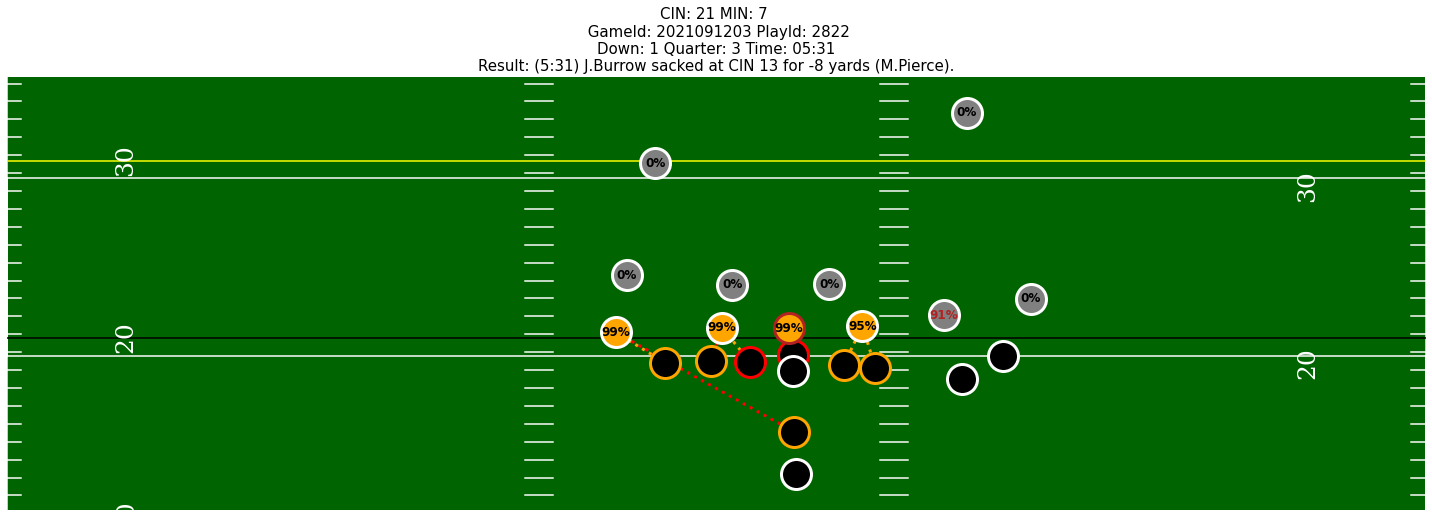

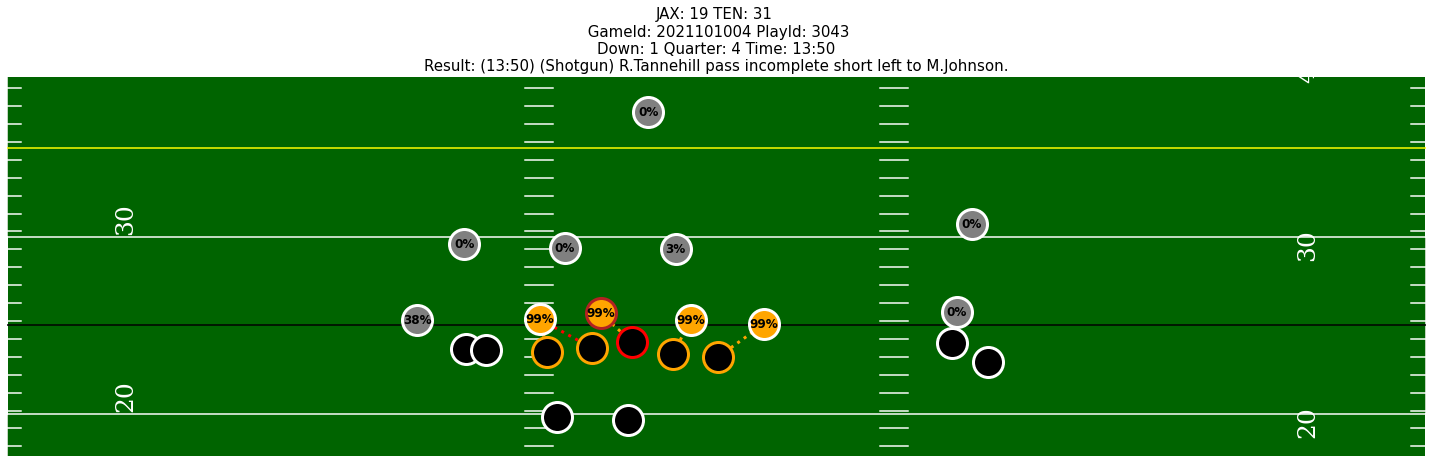

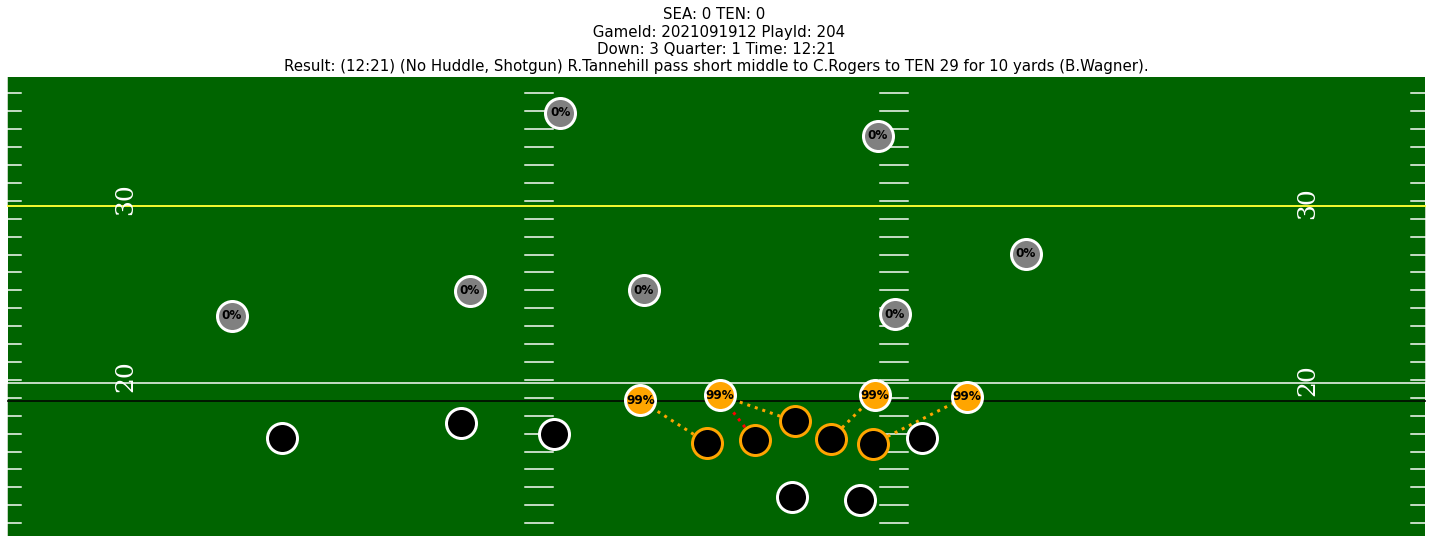

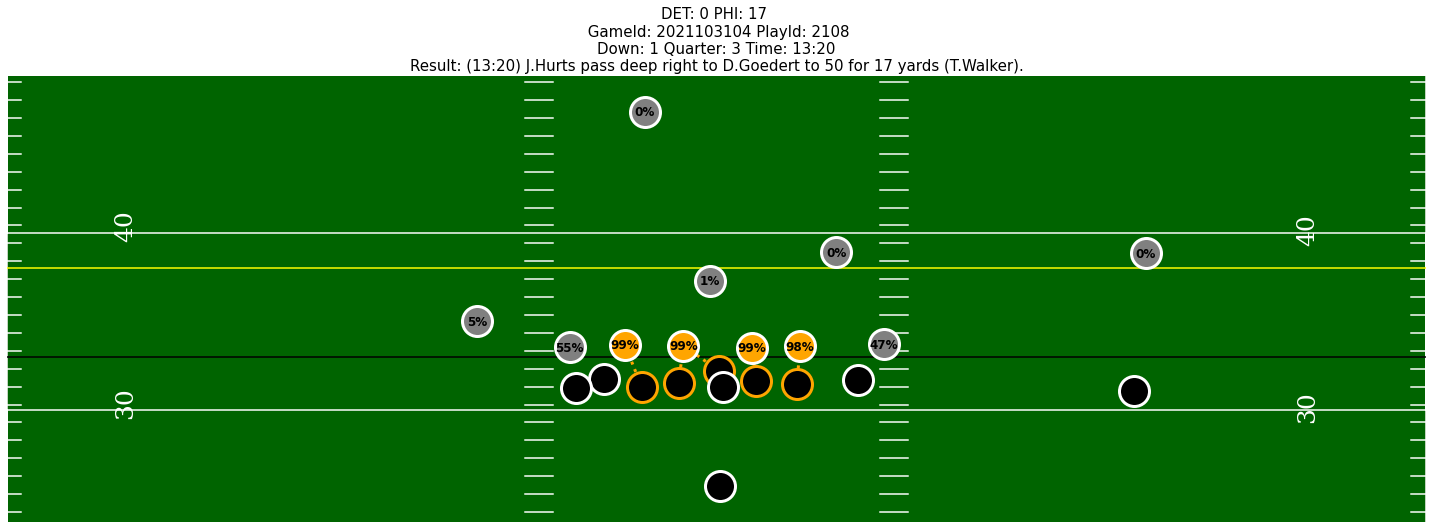

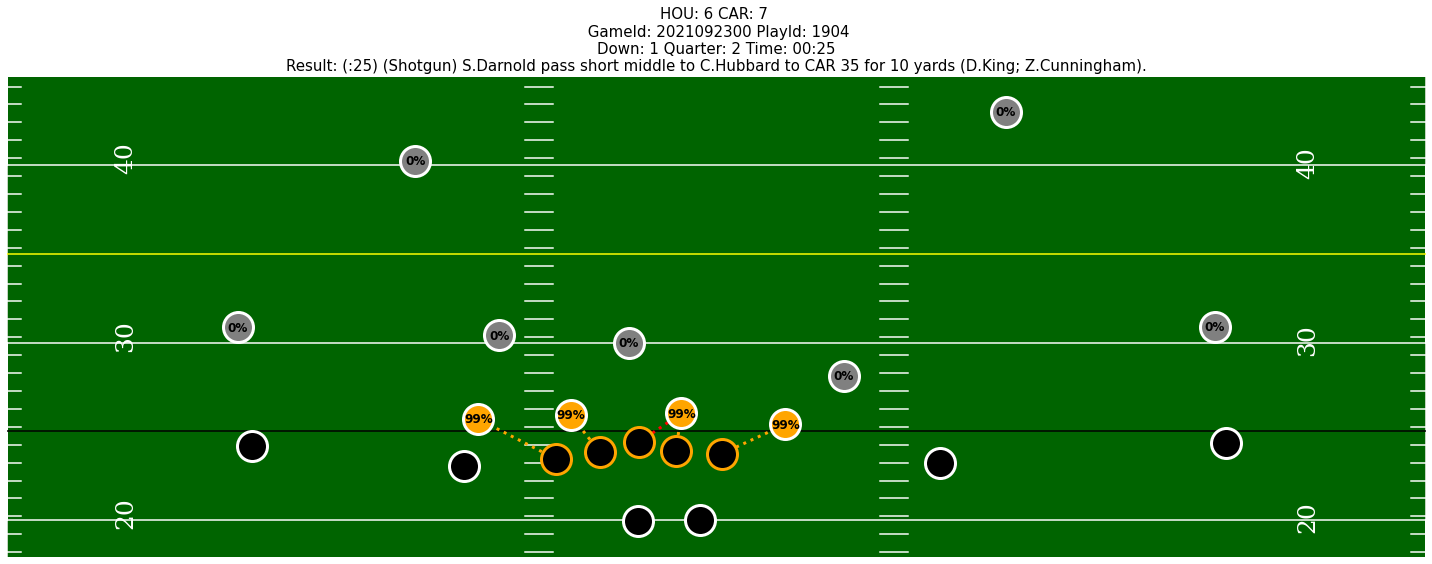

In [24]:
sample = presnap_df_val[(presnap_df_val.pff_sack==1) & (presnap_df_val.blitzId.isin([1,2]))].sample()
gameId = int(sample.gameId)# 2021101400 #2021100300
playId = int(sample.playId)# 962 #1632
inference_loader.run_once(gameId, playId)

sample = presnap_df_val[(presnap_df_val.blitzId.isin([1,2]))].sample()
gameId = int(sample.gameId)# 2021101400 #2021100300
playId = int(sample.playId)# 962 #1632
inference_loader.run_once(gameId, playId)

sample = presnap_df_val.sample()
gameId = int(sample.gameId)# 2021101400 #2021100300
playId = int(sample.playId)# 962 #1632
inference_loader.run_once(gameId, playId)

sample = presnap_df_val.sample()
gameId = int(sample.gameId)# 2021101400 #2021100300
playId = int(sample.playId)# 962 #1632
inference_loader.run_once(gameId, playId)

sample = presnap_df_val.sample()
gameId = int(sample.gameId)# 2021101400 #2021100300
playId = int(sample.playId)# 962 #1632
inference_loader.run_once(gameId, playId)
